<a href="https://colab.research.google.com/github/naimakhan33/-Post-Pruning/blob/main/Fruits_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d moltean/fruits

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 3.94G/3.94G [02:22<00:00, 51.8MB/s]
100% 3.94G/3.94G [02:22<00:00, 29.7MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruits.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
import os
import cv2
import numpy
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, Sequential



In [9]:
# 1. Load dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/fruits-360_100x100/fruits-360/Training',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(100, 100)

)

val_ds = keras.utils.image_dataset_from_directory(
    directory='/content/fruits-360_100x100/fruits-360/Test',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(100, 100)

)

Found 110744 files belonging to 216 classes.
Found 36947 files belonging to 216 classes.


In [10]:
#  Get number of classes
num_classes = len(train_ds.class_names)

In [11]:
# normalize
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds   = val_ds.map(lambda x, y: (x/255.0, y))



In [19]:
# Data augmentation with input shape (set it on the first layer)
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(100, 100, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Create CNN model
model = Sequential()

# Add augmentation block (with input shape)
model.add(data_augmentation)

# Convolution + Pooling layers
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

# Flatten + Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer (multi-class → softmax)
model.add(Dense(num_classes, activation='softmax'))

In [23]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 216)            │        14,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885,464 (11.01 MB)

 Trainable params: 2,885,016 (11.01 MB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
#Compile model
model.compile( optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [28]:
# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [29]:
checkpoint = ModelCheckpoint("best_model.keras",monitor='val_accuracy',  save_best_only=True )

In [30]:
# Train model with callbacks
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 129s 37ms/step - accuracy: 0.5112 - loss: 1.6364 - val_accuracy: 0.7611 - val_loss: 0.8330
Epoch 2/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 128s 37ms/step - accuracy: 0.6071 - loss: 1.2752 - val_accuracy: 0.8320 - val_loss: 0.6316
Epoch 3/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 129s 37ms/step - accuracy: 0.6852 - loss: 1.0156 - val_accuracy: 0.8924 - val_loss: 0.4225
Epoch 4/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - accuracy: 0.7428 - loss: 0.8109 - val_accuracy: 0.9022 - val_loss: 0.3589
Epoch 5/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 144s 38ms/step - accuracy: 0.7908 - loss: 0.6571 - val_accuracy: 0.9054 - val_loss: 0.3051
Epoch 6/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - accuracy: 0.8238 - loss: 0.5439 - val_accuracy: 0.9017 - val_loss: 0.3144
Epoch 7/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 128s 37ms/step - accuracy: 0.8488 - loss: 0.4756 - val_accuracy: 0.9196 - val_loss: 0.2556
Epoch 8/10
3461/3461 ━━━━━━━━━━━━━━━━━━━━ 129s 37ms/step - accuracy: 

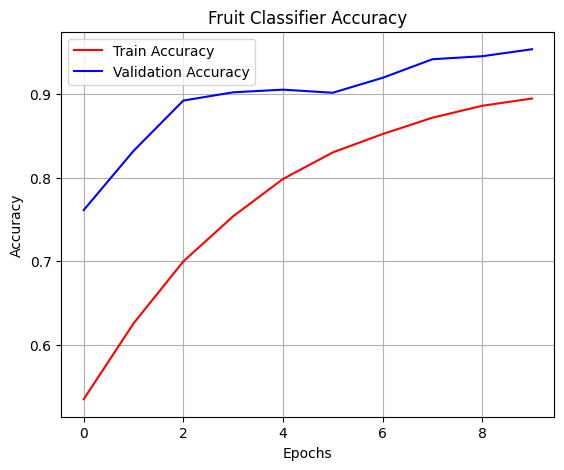

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='red', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.title('Fruit Classifier Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

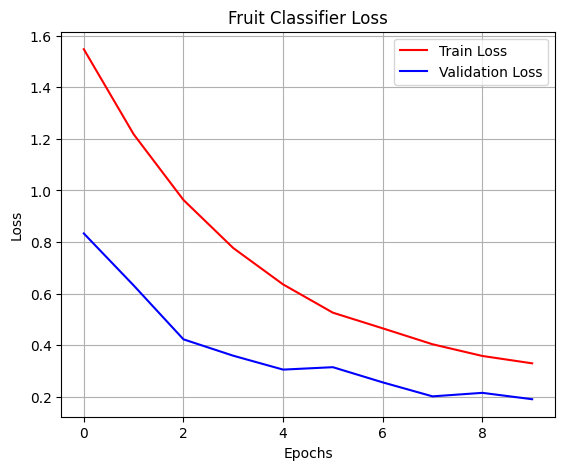

In [34]:
# Loss plot
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red', label='Train Loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation Loss')
plt.title('Fruit Classifier Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()